# Deep Convolutional Generative Adversarial Network

Generative Adversarial Networks (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

This technique is used to help create additional data for imbalanced training sets.

Reference: https://www.tensorflow.org/tutorials/generative/dcgan

Reference: https://poloclub.github.io/ganlab/

The Generator (artist) is trying to create pictures of cats that look real.

The Discriminator (art critic) is trying to determine if they're real or fake.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the generator as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

### *Note*

Ensure you have all required libraries, that's why they're listed below.

Example used TensorFlow '2.9.0'

In [1]:
############################################
# INCLUDES
############################################
#libraries specific to this example
## Imports
import tensorflow as tf
from tensorflow.keras import layers

import glob
import imageio
import matplotlib as matplt
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

warnings.filterwarnings('ignore')               # don't print out warnings


root_location="." + os.sep + "data";

2022-12-16 20:05:37.800330: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Variable declaration

In [2]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "MLGAN"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS
############################################
BUFFER_SIZE = 60000
BATCH_SIZE = 256

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

############################################
# APPLICATION VARIABLES
############################################

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


# Example of Defining a Function

In [3]:
def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("TensorFlow version#:{:>12}".format(tf.__version__))


    return

# Library Invocation
### Note that it's also useful to use this code so that you carry around a list of version dependencies and know how you did something (version)

In [4]:
lib_diagnostics()

[2022-12-16 20:05:46 UTC]   DEBUG: System version    #:3.9.15 (main, Nov  4 2022, 16:13:54) 
[GCC 11.2.0] 
[2022-12-16 20:05:46 UTC]   DEBUG: Matplotlib version#:       3.5.3 
[2022-12-16 20:05:46 UTC]   DEBUG: Numpy version     #:      1.23.4 
[2022-12-16 20:05:46 UTC]   DEBUG: TensorFlow version#:       2.4.1 


## Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

*Note*:
MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.  Reference: https://en.wikipedia.org/wiki/MNIST_database

In [5]:
#load the data and split it into a set of images and labels
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

#make all the data the same size, normalize it
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


2022-12-16 20:05:49.244165: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-16 20:05:49.244641: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib:/usr/lib64:/common/intel/composer_xe_2015.2.164/compiler/lib/intel64/:/common/NCL_6.5.0_gcc485/lib/
2022-12-16 20:05:49.244657: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-16 20:05:49.244679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-361741): /proc/driver/nvidia/version does not exist
2022-12-16 20:05:49.244929: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the followi

## Create the models

Both the generator and discriminator are defined using the Keras Sequential API.

### The Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

LeadyReLU rectifier is also called a rectified linear unit (ReLU). It is an activation function which means, this is how the neuron determines if it's going to fire (weighting of probabilities).  See: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)  The short version is that ReLU is considered an excellent tool and using a vanishing gradient to determine probabilities always making sure any value less than zero is set to 0.

Tanh is another activation function and is specifically used in the output layer because that's where the final decision (yes, no) is made with respect to classification.


In [6]:
def make_generator_model():
    #sequential layer model, one after another
    model = tf.keras.Sequential()
    
    #notice the hyper-parameters provided
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    
    #declaration of the activation function for this first layer
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    #now define a customized layer and notice that the number of "nodes" is now decreasing
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #now define a customized layer and notice that the number of "nodes" is now decreasing
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #now define a customized layer for output and use the tanh for final decision making
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

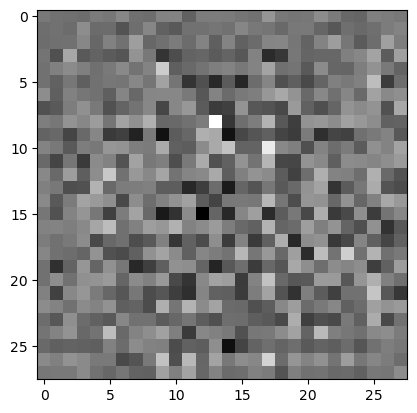

In [7]:
#instantiate a new neural model
generator = make_generator_model()

#create some noise
noise = tf.random.normal([1, 100])

#generate an image
generated_image = generator(noise, training=False)

#show that image.
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


## The Discriminator (artistic review)

The discriminator is a CNN-based image classifier.

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area.

![title](img/cnn.jpg)

![title](img/cnn_sequence.jpg)

References: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[-2.0341151e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.

### What Is a Loss Function and Loss?

In the context of an optimization algorithm, the function used to evaluate a candidate solution (i.e. a set of weights) is referred to as the objective function.  We may seek to maximize or minimize the objective function, meaning that we are searching for a candidate solution that has the highest or lowest score respectively.

Typically, with neural networks, we seek to minimize the error. As such, the objective function is often referred to as a cost function or a loss function and the value calculated by the loss function is referred to as simply “loss.”

The function we want to minimize or maximize is called the objective function or criterion. When we are minimizing it, we may also call it the cost function, loss function, or error function.

The cost or loss function has an important job in that it must faithfully distill all aspects of the model down into a single number in such a way that improvements in that number are a sign of a better model.

The cost function reduces all the various good and bad aspects of a possibly complex system down to a single number, a scalar value, which allows candidate solutions to be ranked and compared.

In calculating the error of the model during the optimization process, a loss function must be chosen.

This can be a challenging problem as the function must capture the properties of the problem and be motivated by concerns that are important to the project and stakeholders.

It is important, therefore, that the function faithfully represent our design goals. If we choose a poor error function and obtain unsatisfactory results, the fault is ours for badly specifying the goal of the search.

### What is Optimization?

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

A current optimization method known as Adam:

    Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
    Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

Reference: https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


The discriminator and the generator optimizers are different since we will train two networks separately.

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [15]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [18]:
#generate and save images
from sys import platform

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  fig_filename='.'+os.sep+'image_at_epoch_{:04d}.png'.format(epoch)
  plt.savefig(fig_filename)
  plt.show()


## Train the model

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. 

*Expect this to take a while depending on the platform you're executing on, get some coffee.*

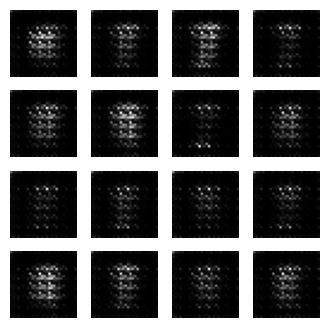

Time for epoch 1 is 115.31653237342834 sec


2022-12-16 20:08:31.186947: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

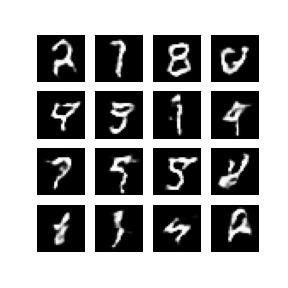

In [21]:
# Display a single image using the epoch number
def display_image(epoch_no):
  fig_filename='.'+os.sep+'image_at_epoch_{:04d}.png'.format(epoch_no)    
  return PIL.Image.open(fig_filename)

display_image(EPOCHS)

In [23]:
#use imageio API calls to create an animated gif using the images saved during training
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)